Dataset loaded with shape: (17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry      

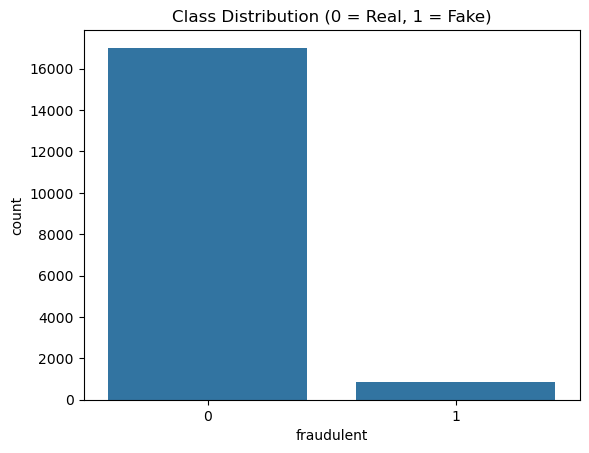

Fake Job Postings: 4.84%
Missing Values (%):
salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403356
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150783
location               0.019351
description            0.000056
dtype: float64
                          title         location department salary_range  \
count                     17880            17534       6333         2868   
unique                    11231             3105       1337          874   
top     English Teacher Abroad   GB, LND, London      Sales          0-0   
freq                        311              718        551          142   

                                          company_profile  \
count                                               14572   
unique                                               

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [1]:
# notebooks/01_EDA.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('../fake_job_postings.csv')



# Show basic info
print(f"Dataset loaded with shape: {df.shape}")
df.info()

# Target distribution
sns.countplot(data=df, x='fraudulent')
plt.title("Class Distribution (0 = Real, 1 = Fake)")
plt.show()

# % of fake jobs
fake_pct = df['fraudulent'].mean() * 100
print(f"Fake Job Postings: {fake_pct:.2f}%")

# Check missing values
missing = df.isnull().mean().sort_values(ascending=False)
print("Missing Values (%):")
print(missing[missing > 0])


# Basic descriptions
print(df.describe(include='object'))

print("\nSample of data:")
df.head()


Class Distribution:
Fraudulent jobs: 866 (4.84%)
Legitimate jobs: 17014 (95.16%)


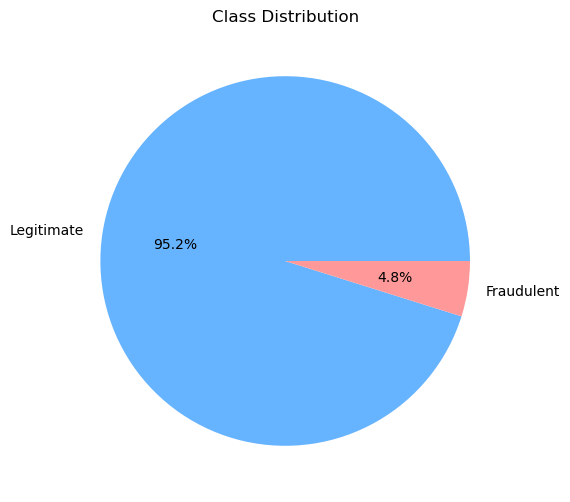


Missing Values Analysis:
                     Missing Values  Percentage
salary_range                  15012   83.959732
department                    11547   64.580537
required_education             8105   45.329978
benefits                       7212   40.335570
required_experience            7050   39.429530
function                       6455   36.101790
industry                       4903   27.421700
employment_type                3471   19.412752
company_profile                3308   18.501119
requirements                   2696   15.078300
location                        346    1.935123
description                       1    0.005593


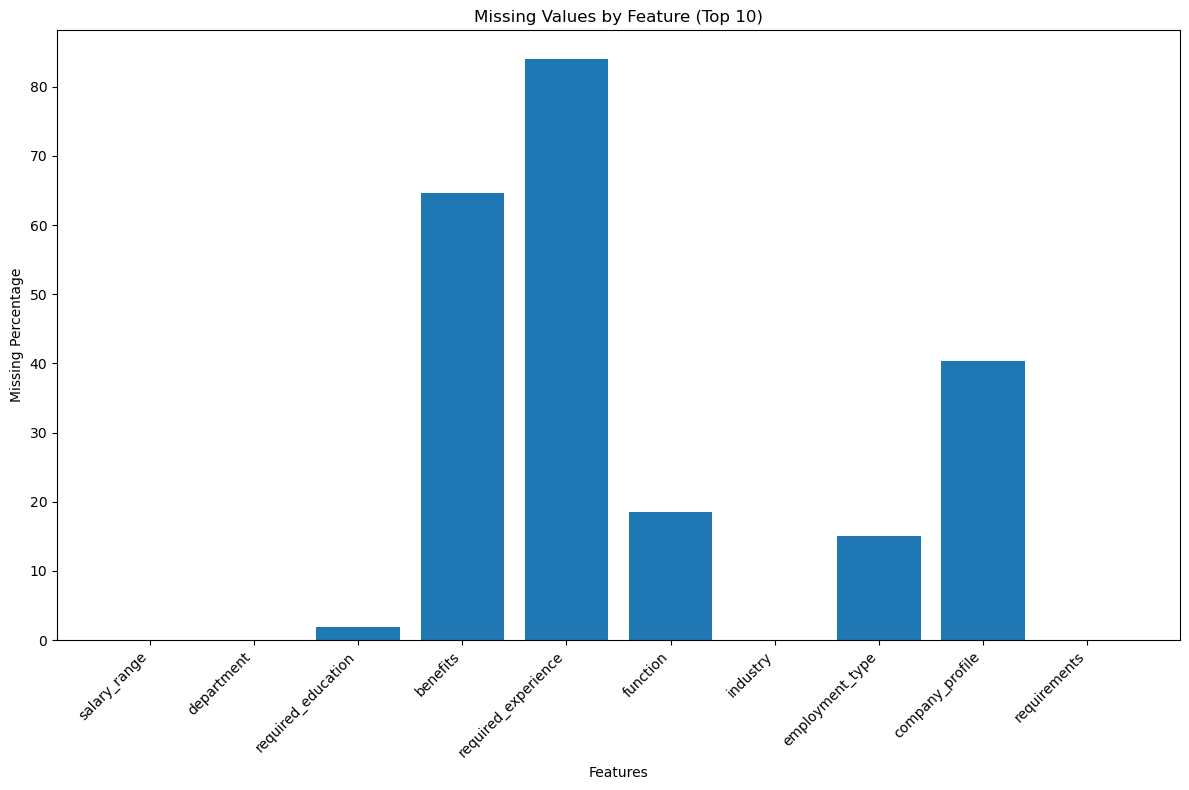

<Figure size 800x500 with 0 Axes>

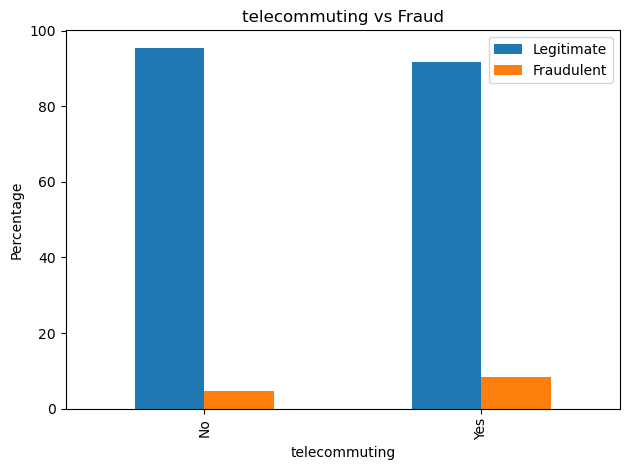

<Figure size 800x500 with 0 Axes>

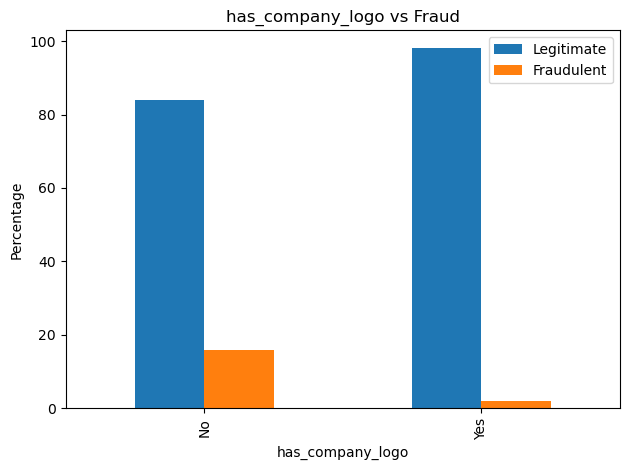

<Figure size 800x500 with 0 Axes>

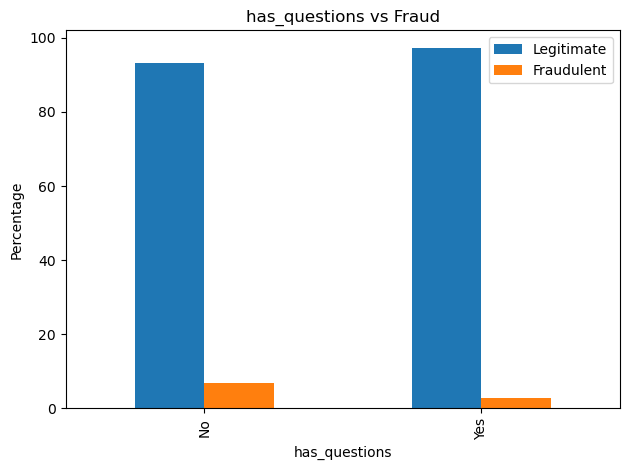

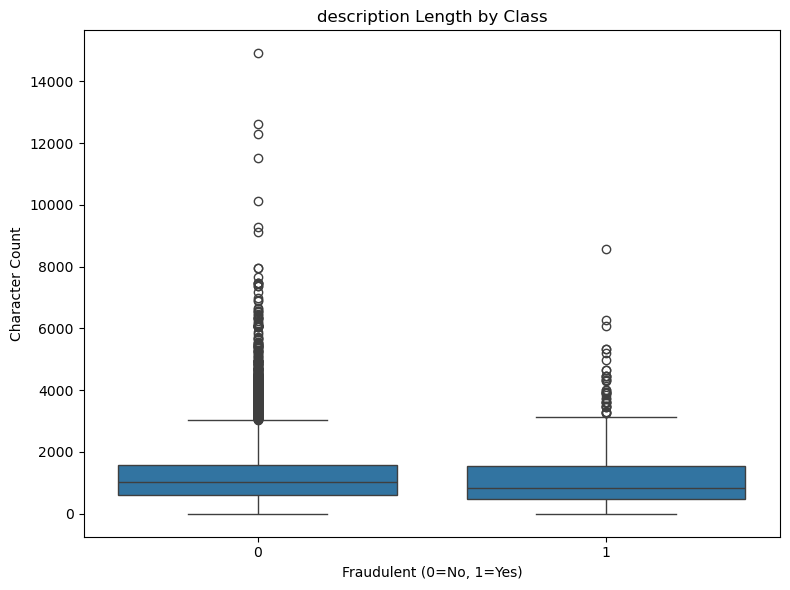

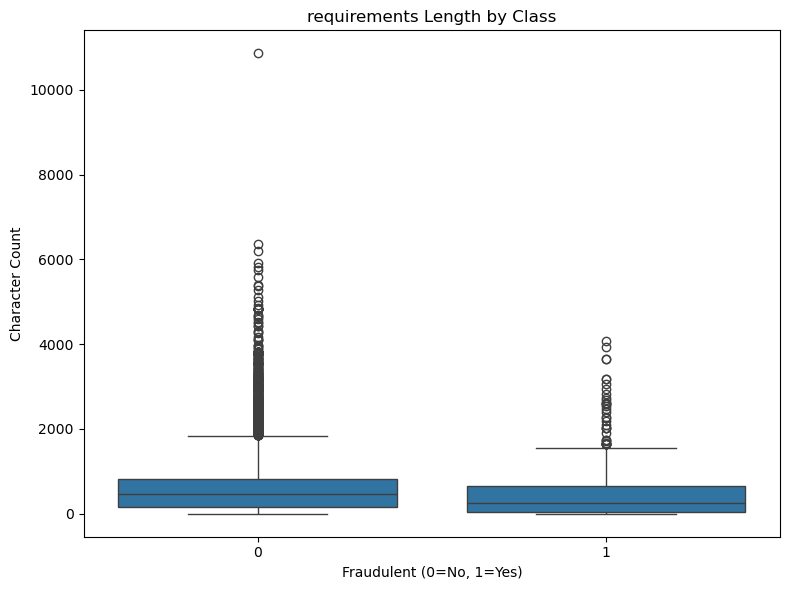

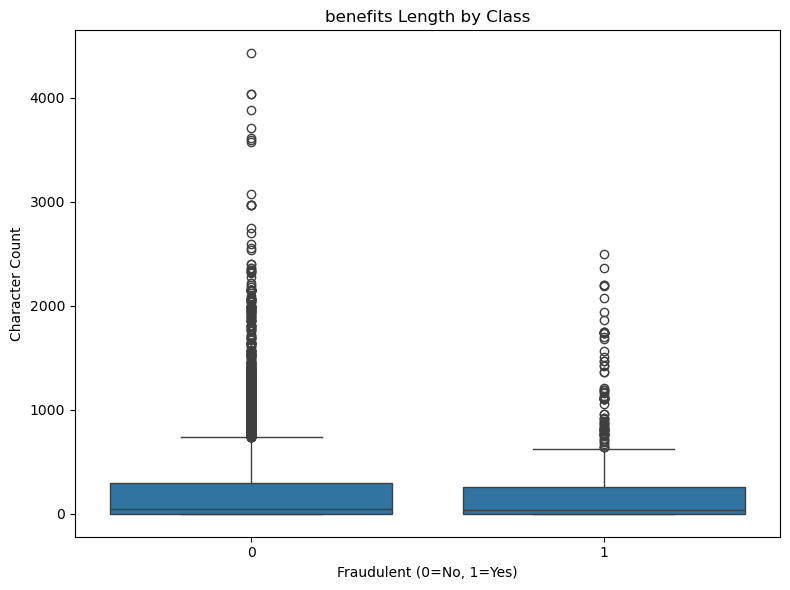

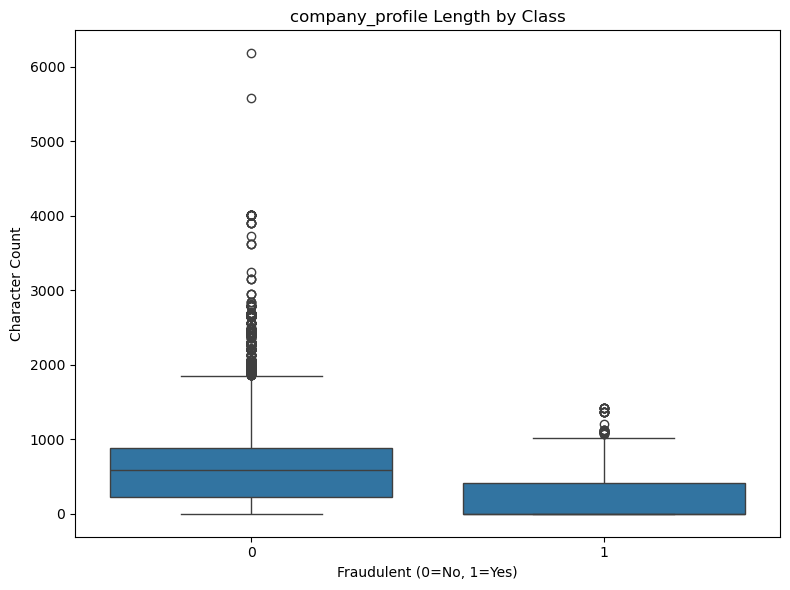

In [2]:
# Check class distribution
fraud_count = df['fraudulent'].sum()
legitimate_count = len(df) - fraud_count
print(f"Class Distribution:")
print(f"Fraudulent jobs: {fraud_count} ({fraud_count/len(df)*100:.2f}%)")
print(f"Legitimate jobs: {legitimate_count} ({legitimate_count/len(df)*100:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.pie([legitimate_count, fraud_count], 
        labels=['Legitimate', 'Fraudulent'],
        autopct='%1.1f%%', 
        colors=['#66b3ff', '#ff9999'])
plt.title('Class Distribution')
plt.show()

# Check missing values
missing_values = df.isnull().sum()
missing_percentage = missing_values / len(df) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values('Percentage', ascending=False)

print("\nMissing Values Analysis:")
print(missing_df[missing_df['Missing Values'] > 0])

# Visualize missing values
plt.figure(figsize=(12, 8))
plt.bar(missing_df.index[:10], missing_percentage[:10])
plt.title('Missing Values by Feature (Top 10)')
plt.xlabel('Features')
plt.ylabel('Missing Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze binary features
if 'telecommuting' in df.columns and 'has_company_logo' in df.columns and 'has_questions' in df.columns:
    binary_features = ['telecommuting', 'has_company_logo', 'has_questions']
    
    # Create a separate figure for each binary feature to avoid empty plots
    for feature in binary_features:
        plt.figure(figsize=(8, 5))
        cross_tab = pd.crosstab(df[feature], df['fraudulent'], normalize='index') * 100
        cross_tab.plot(kind='bar', stacked=False)
        plt.title(f'{feature} vs Fraud')
        plt.xlabel(feature)
        plt.ylabel('Percentage')
        plt.xticks([0, 1], ['No', 'Yes'])
        plt.legend(['Legitimate', 'Fraudulent'])
        plt.tight_layout()
        plt.show()

# Analyze text field lengths
text_columns = ['description', 'requirements', 'benefits', 'company_profile']
text_columns = [col for col in text_columns if col in df.columns]

# Create new features for text lengths
for col in text_columns:
    df[f'{col}_length'] = df[col].fillna('').apply(len)

# Visualize text lengths by class - one figure per text column
for col in text_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='fraudulent', y=f'{col}_length', data=df)
    plt.title(f'{col} Length by Class')
    plt.xlabel('Fraudulent (0=No, 1=Yes)')
    plt.ylabel('Character Count')
    plt.tight_layout()
    plt.show()

### 📌 Key Observations
- Fraudulent jobs are <X>% of total — strong class imbalance.
- Fields like `description`, `requirements`, and `company_profile` show shorter length for fake jobs.
- Missing values present in `benefits`, `salary_range`, `company_profile`.
- `has_company_logo = 0` correlates strongly with fraud.
